In [14]:
# !pip install -e ../.

from climpyrical.datacube import *
from climpyrical.mask import *
from climpyrical.gridding import *

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd

from sklearn import ensemble
import seaborn as sns
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats
from pykrige.ok import OrdinaryKriging


from sklearn.metrics.pairwise import paired_distances
from scipy.spatial import distance
from scipy.stats import linregress

import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots
import chart_studio.plotly as py
from plotly import colors as clr
import chart_studio

chart_studio.tools.set_config_file(world_readable=False,
                             sharing='private')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# PATH_MASK = '../../climpyrical/tests/data/'
PATH = '../../climpyrical/tests/data/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load.nc'
PATH_MEAN = '../../climpyrical/tests/data/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
# PATH = '../../climpyrical/tests/data/hdd_CanRCM4-LE_ens35_1951-2016_ann_ta.nc'
# PATH_MEAN = '../../climpyrical/tests/data/hdd_CanRCM4-LE_ens35_1951-2016_ann_ensmean.nc'
# print(xr.open_dataset(PATH))
# dv = 'heating_degree_days_per_time_period'
dv = 'snw'

dsold = read_data(PATH, dv)
ds_mean = read_data(PATH_MEAN, dv, ['rlon', 'rlat'])
ds_mean.keys()

N = 1
ds = regrid_ensemble(dsold, dv, N)

if 'time' in ds_mean.keys():
    ds_mean = regrid_ensemble(ds_mean.squeeze('time'), dv, N, ['rlon', 'rlat'])
else:
    ds_mean = regrid_ensemble(ds_mean, dv, N, ['rlon', 'rlat'])
mean = ds_mean[dv].values
        
dvmask = 'sftlf'
mask = read_data('../../climpyrical/tests/data/land_mask_CanRCM4_sftlf.nc', dvmask, keys=['rlat', 'rlon'])
if 'time' in mask.keys():
    mask = mask.squeeze('time')
    mask = mask.drop('time')
mask = regrid_ensemble(mask, dvmask, N, ['rlon', 'rlat'])
mask = mask[dvmask].values >= 1.0

assert mean.shape == ds[dv].values[0, ...].shape

In [16]:
final_mask = np.logical_and(mask.copy(), ~np.isnan(mean))
assert final_mask.shape == mean.shape

In [17]:
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
assert rlon.shape == rlat.shape and rlon.shape == final_mask.shape

In [18]:
# df_path = '../../climpyrical/tests/data/Interim_hdd_Tmax_Tmin_delivered.csv'
df_path = '../../climpyrical/tests/data/sl50_short.csv'
df = pd.read_csv(df_path, index_col=None)
# station_dv = 'HDD (degC-day)'
station_dv = 'SL50 (kPa)'

# transform into rotated pole
rlon_st, rlat_st = transform_coords(df['lon'].values, df['lat'].values)

df = df.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)

target = '+proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'
df.shape

(520, 9)

In [19]:
rlon_st, rlat_st = transform_coords(df['lon'].values, df['lat'].values)
df = df.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)

# find nearest grid cells to station locations in rlon and rlat using haversine distance
nearest_gridcell_idx = pairwise_distances_argmin_min( 
    np.deg2rad(
    np.stack([df.rlon, df.rlat]).T
    ),
    np.deg2rad(np.stack([rlon.copy().flatten(), rlat.copy().flatten()]).T), 
    metric='haversine'
)[0]

nearest_gridcell_idx_masked = pairwise_distances_argmin_min( 
    np.deg2rad(
    np.stack([df.rlon, df.rlat]).T
    ),
    np.deg2rad(np.stack([rlon.copy()[final_mask], rlat.copy()[final_mask]]).T), 
    metric='haversine'
)[0]

# create a mesh of indices of rlon and rlat grids for masking 
irlon, irlat = np.meshgrid(range(ds.rlon.size), range(ds.rlat.size))
# combine indices and extract the nearest grid cell index in x and y axis
ix_non_agg, iy_non_agg = np.stack([irlon.flatten(), irlat.flatten()])[:, nearest_gridcell_idx]
ix_non_agg_masked, iy_non_agg_masked = np.stack([irlon[final_mask], irlat[final_mask]])[:, nearest_gridcell_idx_masked]

# where_nan = np.isnan(mean[iy_non_agg, ix_non_agg])
# ix_non_agg[where_nan] = ix_non_agg_masked[where_nan]
# iy_non_agg[where_nan] = iy_non_agg_masked[where_nan]


# add to dataframe
matched_df = pd.DataFrame({'ilocy': iy_non_agg, 'ilocx': ix_non_agg, 'ilocy_mask': iy_non_agg_masked, 'ilocx_mask': ix_non_agg_masked, station_dv: df[station_dv],'rlat':df.rlat, 'rlon':df.rlon, 'lat': df.lat, 'lon':df.lon, 'station_name':df.station_name})
# aggregate stations in same grid cell by taking mean
matched_df.to_csv('/home/nannau/06172020/dash-dv-explorer/assets/data/snow_stations.csv')
matched_df = matched_df.groupby(['ilocy', 'ilocx'], as_index=False).agg({station_dv: 'mean', 'ilocx_mask': 'mean', 'ilocy_mask': 'mean', 'rlat':'mean', 'rlon':'mean', 'lat': 'mean', 'lon': 'mean', 'station_name': 'first'})#, 'niy': 'min', 'nix': 'min'})


iy = matched_df.ilocy.values
ix = matched_df.ilocx.values
iym, ixm = matched_df.ilocy_mask.values.astype(int), matched_df.ilocx_mask.values.astype(int)

where_nan = np.isnan(ds_mean[dv].values[iy, ix])

station_vals = matched_df[station_dv].values

# comment out for station rlon,rlat
matched_df['rlon'] = rlon[iy, ix]
matched_df['rlat'] = rlat[iy, ix]

matched_df.head()

,ilocy,ilocx,SL50 (kPa),ilocx_mask,ilocy_mask,rlat,rlon,lat,lon,station_name
0,55,100,0.90,100.0,55.0,-4.464804,10.251430,42.275600,-82.95560,WINDSOR A
1,56,100,1.20,100.0,56.0,-4.017983,10.251430,42.333300,-82.93330,WINDSOR RIVERSIDE
2,57,101,1.50,101.0,57.0,-3.571161,10.697144,42.992200,-82.30470,SARNIA AIRPORT
3,57,104,1.55,104.0,57.0,-3.571161,12.034287,42.820545,-80.48953,DELHI CDA
4,58,103,1.65,103.0,58.0,-3.124339,11.588573,43.017550,-81.09195,DORCHESTER


In [20]:
np.any(where_nan)
where_nan.shape, ix.shape, ixm.shape
ix[where_nan], ixm[where_nan]

(array([106, 102,  99, 126,  95, 125, 126, 127, 131, 135, 132, 127, 128,
        129,  38, 126, 127, 129,  38, 130, 131,  38, 129, 131,  37, 129,
         37, 132, 123, 138,  33,  34, 132, 138, 141, 126, 132, 140, 132,
         34, 132,  31, 131, 139, 136, 131,  31, 133,  31, 106]),
 array([106, 102, 100, 127,  95, 124, 127, 127, 130, 132, 132, 126, 128,
        129,  39, 126, 126, 129,  39, 132, 132,  39, 132, 132,  38, 132,
         36, 133, 123, 138,  34,  35, 133, 138, 141, 126, 133, 140, 133,
         35, 133,  34, 133, 138, 136, 131,  30, 133,  31, 107]))

In [23]:
def regionalize(array):
    return array[u:lw, l:r].reshape((lw-u, r-l))
def squareize(array):
    ar = mean.copy()
    ar[final_mask] = array
    ar[~final_mask] = np.nan
    return ar
mean = ds_mean[dv].values
mean[iy[where_nan], ix[where_nan]] = mean[iym[where_nan], ixm[where_nan]]
oldmean = mean.copy()
meanc = mean.copy()
tol = np.linspace(0.1, 10, 10000)

print(np.nanmean(station_vals - meanc[iy, ix]))

if np.nanmean(station_vals - meanc[iy, ix]) >= 0:
    rmtols = np.array([np.mean(matched_df[station_dv] - (meanc[iy, ix]/t)) for t in tol])
    best_tol = tol[np.where(np.diff(np.sign(rmtols)) != 0.)[0]]

# if np.mean(matched_df[station_dv] - meanc[iy, ix]) < 0:
#     rmtols = np.array([np.mean(matched_df[station_dv] + (meanc[iy, ix]/t)) for t in tol])
#     best_tol = tol[np.where(np.diff(np.sign(rmtols)) != 0.)[0]]

mean = meanc/best_tol
print(best_tol, np.mean(matched_df[station_dv] - mean[iy, ix]))


np.mean(station_vals - mean[iy, ix])
# print(np.mean(matched_df[station_dv] - meanc[iy, ix]))
# print(np.mean(matched_df[station_dv] - mean[iy, ix]))

0.996397158660852
[0.7] -0.00235668955536179


nan

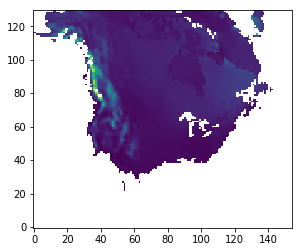

In [24]:
plt.imshow(mean, origin='lower')

In [25]:
newmean = meanc/best_tol

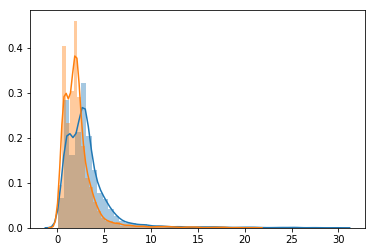

In [26]:
sns.distplot(newmean[final_mask])
sns.distplot(meanc[final_mask])

In [27]:
assert np.sum(~np.isclose(rlon[iy_non_agg, ix_non_agg], df.rlon, atol=0.6)) < 6

In [28]:
# subset of grid cells closest station locations
X = np.stack([rlon[iy, ix], rlat[iy, ix], mean[iy, ix]]).T

# full set of locations we wish to predict a value at
Xf = np.stack([rlon[final_mask], rlat[final_mask], mean[final_mask]]).T

In [29]:
# from sklearn.gaussian_process.kernels import ConstantKernel

# C_0, rho, length_scale = [0.0762, 1.13, 129/2]

In [30]:
# from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, RBF, RBFMOD
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.model_selection import GridSearchCV

# kernel = ConstantKernel(C_0)+ConstantKernel(rho)*RBFMOD(length_scale)
# krig = GaussianProcessRegressor(alpha=5, random_state=0, kernel=kernel)    

# # clf = GridSearchCV(krig, kernel)
# krig.fit(X, station_vals)

# # sorted(krig.cv_results_.keys())

# krigfield = [krig.predict(Xf)]
# # print(krig.kernel)

# # plt.scatter(station_vals, squareize(krigfield[0])[iy, ix])
# # np.sqrt(mean_squared_error(S[iy, ix], station_vals))

In [31]:
ratio = station_vals/mean[iy, ix] #np.var(station_vals, mean[iy, ix])
matched_df = matched_df.assign(ratio=ratio)
def undo(x, mean):
    return x*mean

def undo_rho(x, mean, rho):
    return ((np.ones(x.shape)-rho)+x)*mean

assert np.any(~np.isnan(ratio))

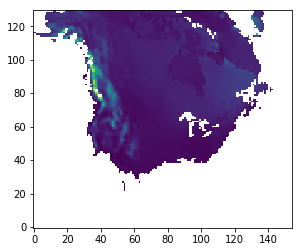

In [32]:
plt.imshow(ds_mean[dv].values, origin='lower')

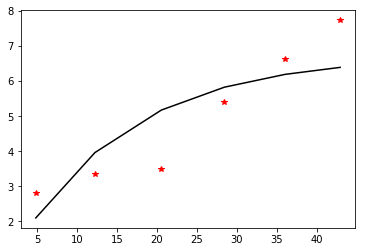

[ 6.47674342 42.95227504  0.2378471 ]


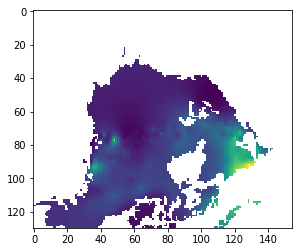

In [33]:
# import numpy as np
# from pykrige.rk import Krige
# from pykrige.compat import GridSearchCV


# # 2D Kring param opt

# param_dict = {
#     "method": ["ordinary"],
#     "variogram_model": ["linear", "power", "gaussian", "exponential", "spherical"],
#     # "nlags": [4, 6, 8],
#     # "weight": [True, False]
# }


# estimator = GridSearchCV(Krige(), param_dict, verbose=True)

# # dummy data

# # run the gridsearch
# X = np.stack([dfc.rlon, dfc.rlat]).T
# y = dfc[station_dv]
# estimator.fit(X=X, y=y)


# if hasattr(estimator, "best_score_"):
#     print("best_score R² = {:.3f}".format(estimator.best_score_))
#     print("best_params = ", estimator.best_params_)

# print("\nCV results::")
# if hasattr(estimator, "cv_results_"):
#     for key in [
#         "mean_test_score",
#         "mean_train_score",
#         "param_method",
#         "param_variogram_model",
#     ]:
#         print(" - {} : {}".format(key, estimator.cv_results_[key]))

from pykrige.ok import OrdinaryKriging

okie = OrdinaryKriging(matched_df.rlon, matched_df.rlat, matched_df[station_dv], variogram_model='exponential', exact_values=False, coordinates_type = "geographic")
krigfield = okie.execute('points', rlon[final_mask], rlat[final_mask])
okie.display_variogram_model()
print(okie.variogram_model_parameters)

S = mean.copy()
S[final_mask] = krigfield[0]
S[~final_mask] = np.nan
plt.imshow(S)

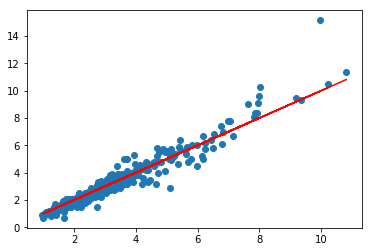

In [34]:
plt.scatter(S[iy, ix], matched_df[station_dv])
plt.plot(S[iy, ix],S[iy, ix], color='red')

/home/nannau/tri/lib/python3.6/site-packages/matplotlib/image.py:412: RuntimeWarning:

invalid value encountered in subtract



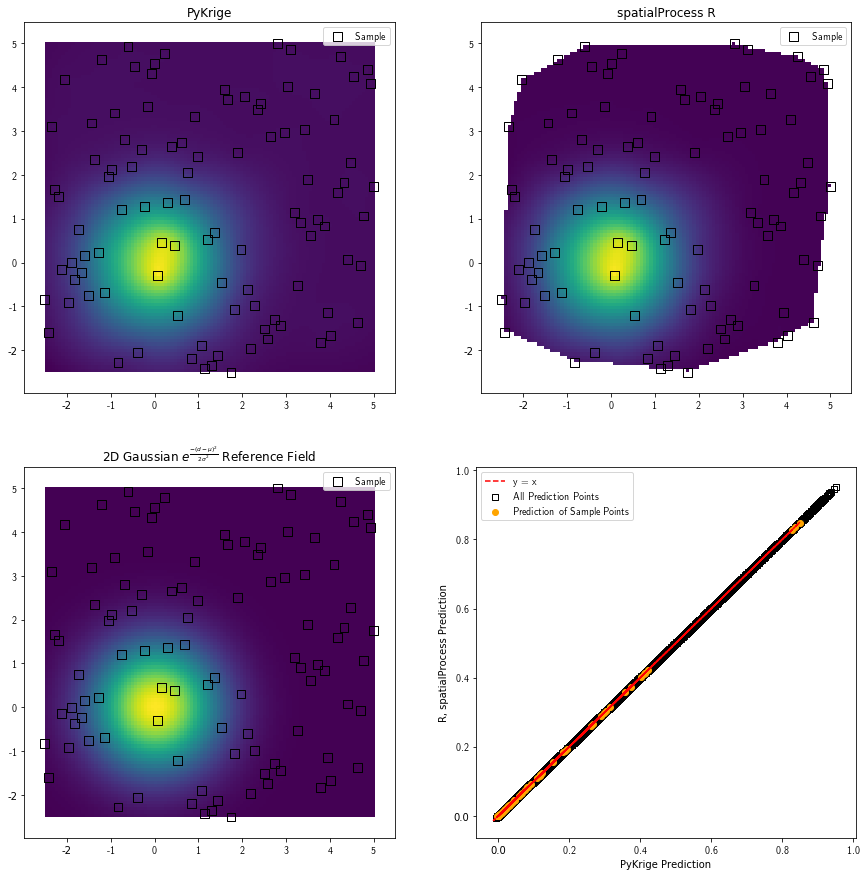

In [35]:
import matplotlib.pyplot as plt
import random
import climpyrical.spytialProcess as sp
from climpyrical.gridding import *
import numpy as np
from pykrige.ok import OrdinaryKriging

def expvar(params, x):
    s, r, n = params
    return n+s*(1.0-np.exp(-x/r))

n = 100
x = np.linspace(-2.5, 5, n)
y = np.linspace(-2.5, 5, n)
random.seed(47)
i, j = random.sample(range(x.size),n), random.sample(range(x.size),n)

xx, yy = np.meshgrid(x, y)
d = np.sqrt(xx*xx+yy*yy)
sigma, mu = 1.0, 0.0
z = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
z_sample = z[j, i]
xs, ys = xx[j, i], yy[j, i]

xn, yn = flatten_coords(x, y)

zpred, x1, y1, cov = sp.fit(np.stack([xs, ys]), z_sample, x.size, y.size)
nugget, sill, r = cov['sigma.MLE'][0]**2, cov['rho.MLE'][0], cov['theta.MLE'][0]
nanmask = ~np.isnan(zpred)

uk = OrdinaryKriging(
    xs, ys, z_sample, variogram_model="custom", 
    exact_values=False, variogram_function=expvar, variogram_parameters=[sill, r, nugget]
)
y_pred, y_std = uk.execute('points', xn, yn, backend="loop")
y_pred = y_pred.reshape(z.shape)
from matplotlib import rc

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
rc('text', usetex=True)

ax[0,0].imshow(y_pred, origin='lower', label='PyKrige', extent=[xs.min(), xs.max(), ys.min(), ys.max()])
ax[0,0].set_title("PyKrige")
ax[0,0].scatter(xs, ys, marker='s', s=80, facecolors='none', edgecolors='black', label='Sample')
ax[0,0].legend()

ax[1,0].imshow(z, vmin=0, vmax=1, origin='lower', extent=[xs.min(), xs.max(), ys.min(), ys.max()])
ax[1,0].set_title("2D Gaussian $e^{\\frac{-(d-\\mu)^2}{2\\sigma^2}}$ Reference Field")
ax[1,0].scatter(xs, ys, marker='s', s=80, facecolors='none', edgecolors='black', label='Sample')
ax[1,0].legend()

ax[0,1].imshow(zpred.T, origin='lower', label='spatialProcess', extent=[xs.min(), xs.max(), ys.min(), ys.max()])
ax[0,1].set_title("spatialProcess R")
ax[0,1].scatter(xs, ys, marker='s', s=80, facecolors='none', edgecolors='black', label='Sample')
ax[0,1].legend()

ax[1,1].scatter(y_pred.T[nanmask].flatten(), zpred[nanmask].flatten(), marker='s',facecolors='none', edgecolors='black', label='All Prediction Points')
ax[1,1].set_xlabel('PyKrige Prediction')
ax[1,1].set_ylabel('R, spatialProcess Prediction')
ax[1,1].scatter(y_pred.T[j, i].flatten(), zpred[j, i].flatten(), marker='o', color='orange', label='Prediction of Sample Points')
ax[1,1].plot(y_pred.T[j, i].flatten(), y_pred.T[j, i].flatten(), '--', color='red', label='y = x')
ax[1,1].legend()

plt.savefig('spatialProcess_vs_PyKrige_modified')

/home/nannau/tri/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning:

invalid value encountered in subtract



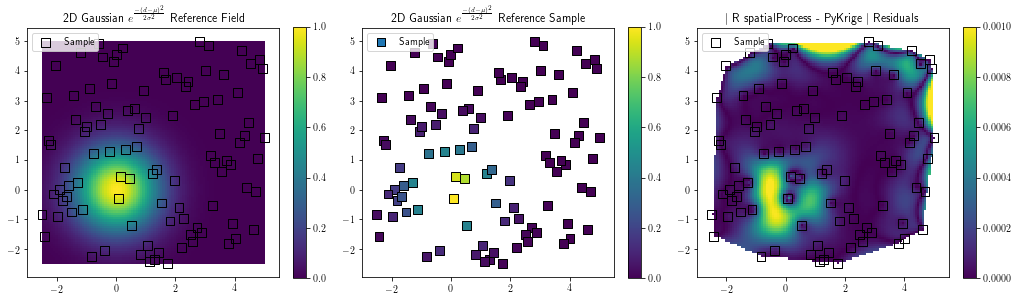

In [36]:
# assert_allclose(y_pred.T[nanmask], zpred[nanmask])

# assert_allclose(y_pred.T[nanmask].flatten(), zpred[nanmask].flatten(), atol=0.005)
fig, ax = plt.subplots(1, 3, figsize=(17, 10))
col = ax[0].imshow(z, vmin=0, vmax=1, origin='lower', extent=[xs.min(), xs.max(), ys.min(), ys.max()])
ax[0].set_title("2D Gaussian $e^{\\frac{-(d-\\mu)^2}{2\\sigma^2}}$ Reference Field")
ax[0].scatter(xs, ys, marker='s', s=80, facecolors='none', edgecolors='black', label='Sample')
ax[0].legend()
plt.colorbar(col, ax=ax[0], fraction=0.045)

empty = np.empty(z.shape)
empty[:] = np.nan

cbar = ax[1].imshow(empty, origin='lower', vmin=0, vmax=1, extent=[xs.min(), xs.max(), ys.min(), ys.max()])
ax[1].set_title("2D Gaussian $e^{\\frac{-(d-\\mu)^2}{2\\sigma^2}}$ Reference Sample")
ax[1].scatter(xs, ys, marker='s', s=80, facecolors='none', c=z_sample, edgecolors='black', label='Sample')
ax[1].legend()
plt.colorbar(cbar, ax = ax[1], fraction=0.045)

col_res = ax[2].imshow(np.abs(np.subtract(y_pred.T, zpred)).T, vmin=0, vmax=.001, origin='lower', extent=[xs.min(), xs.max(), ys.min(), ys.max()])
ax[2].set_title('$\mid$ R spatialProcess - PyKrige $\mid$ Residuals')
ax[2].scatter(xs, ys, marker='s', s=80, facecolors='none', edgecolors='black', label='Sample')
ax[2].legend()
plt.colorbar(col_res, ax=ax[2], fraction=0.045)

plt.savefig('residual_pykrige_spatialProcess')
# plt.imshow(np.corrcoef(y_pred.T, zpred), vmin=0.9, vmax=1)

/home/nannau/tri/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in true_divide



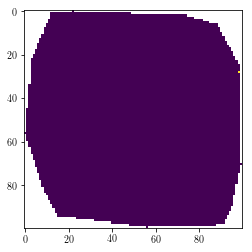

In [37]:
plt.imshow(y_pred/zpred)

In [38]:
y_pred[~np.isnan(zpred)].flatten(), zpred[~np.isnan(zpred)].flatten()

(array([ 0.02576913,  0.01372754,  0.01694367, ..., -0.00062512,
        -0.00064244, -0.00260754]),
 array([3.10479402e-02, 1.49360678e-02, 1.77689810e-02, ...,
        7.39817113e-05, 2.72302890e-08, 8.20170112e-07]))

In [39]:
# !cd "/home/nannau/06172020/climpyrical/"; bash r_install.sh
from rpy2.robjects.packages import importr

importr("fields")#, lib_loc="../../r-library/fields/")
# importr("sp", lib_loc="../../r-library/sp/")
# importr("gstat", lib_loc="../../r-library/gstat/")
# importr("geoR", lib_loc="../../r-library/geoR/")

rpy2.robjects.packages.Package as a <module 'fields'>

In [40]:
dfc = matched_df.copy()

In [41]:
from shapely.geometry import Point, Polygon
import climpyrical.spytialProcess as sp

pairs = {
    'north': {
        'x1': -90,
        'x2': -50,
        'y1': 40,
        'y2': 60
    },
    'east': {
        'x1': -140,
        'x2': -100,
        'y1': 55,
        'y2': 80
    },
    'west': {
        'x1': -140,
        'x2': -90,
        'y1': 48,
        'y2': 60
    }
    
}

Z = mean.copy()
Z_py = mean.copy()
Z_py[...] = np.nan
Z[...] = np.nan

# for key in pairs:
key = 'north'
lon1, lon2 = pairs[key]['x1'], pairs[key]['x2']
lat1, lat2 = pairs[key]['y1'], pairs[key]['y2']

dfc = matched_df.copy()

dfc = dfc.assign(ratio = ratio)

region_cond = ((dfc.lon > lon1) & (dfc.lon < lon2) & (dfc.lat > lat1) & (dfc.lat < lat2))
region_cond_df = ((df.lon > lon1) & (df.lon < lon2) & (df.lat > lat1) & (df.lat < lat2))

dfc = dfc[region_cond]

p1 = (dfc.rlon.min(), dfc.rlat.min())
p2 = (dfc.rlon.max(), dfc.rlat.min())
p3 = (dfc.rlon.max(), dfc.rlat.max())
p4 = (dfc.rlon.min(), dfc.rlat.max())

l, rside = find_nearest_index(ds.rlon.values, dfc.rlon.min()), find_nearest_index(ds.rlon.values, dfc.rlon.max())
l, r = find_nearest_index(ds.rlon.values, dfc.rlon.min()), find_nearest_index(ds.rlon.values, dfc.rlon.max())

u, lw = find_nearest_index(ds.rlat.values, dfc.rlat.min()), find_nearest_index(ds.rlat.values, dfc.rlat.max())

final_mask_c = final_mask.copy()
region = final_mask.copy() 
region[...] = False
region[u:lw, l:r] = True


# If True, keep station locations in the mask
final_mask_c[iy, ix] = True
# combine region mask and land mask
region = np.logical_and(final_mask_c, region)
region[dfc.ilocy, dfc.ilocx] = True

latlon = np.stack([dfc.rlon, dfc.rlat])
#     stats = dfc['ratio'].values
stats = dfc[station_dv].values

ylim = lw-u
xlim = r-l
z, x, y, cov = sp.fit(latlon, stats, xlim, ylim)

#     okie = OrdinaryKriging(dfc.rlon, dfc.rlat, stats, variogram_model='exponential', exact_values=False, coordinates_type = "geographic")
#     krigfield = okie.execute('points', rlon[region], rlat[region])[0]

Z[u:lw, l:rside] = z.T#*mean[u:lw, l:rside]
#     Z_py[region] = krigfield


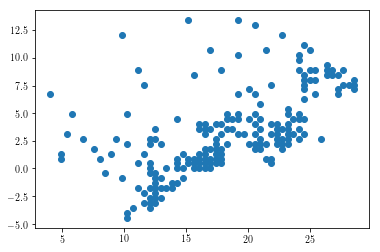

In [42]:
plt.scatter(dfc.rlon, dfc.rlat)

In [43]:
# print(cov.keys())
nugget, sill, r = cov['sigma.MLE'][0]**2, cov['rho.MLE'][0], cov['theta.MLE'][0]

In [44]:
nugget, sill, r, cov['N'][0], cov['cov.function.name'][0]

(1.3725103185788827,
 3.139088089722545,
 621.412248428073,
 192,
 'stationary.cov')

In [45]:
cov.keys()
cov['lnProfileLike.FULL']

-340.545445


In [46]:
# from skgstat import Variogram
# V = Variogram(latlon.T, stats, normalize=False, n_lags=30)
# x = np.linspace(0, 25.0)
# def exp(nugget, sill, r, x):
#     return nugget + sill*(1.-np.exp(-x/r))
# V.plot()
# plt.show()
# plt.plot(x, exp(nugget, sill, r, x))
# plt.show()

In [47]:
import matplotlib

from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KDTree

std = StandardScaler() 
N = 10
db = KMeans(n_clusters=N)
# db = DBSCAN(eps=0.2, min_samples=30, metric='haversine')

X = np.stack([matched_df.rlon, matched_df.rlat])
# X
X = std.fit_transform(X.T)
db.fit(X)

db.labels_.shape, matched_df.shape[0]

matched_df = matched_df.assign(label = db.labels_)

# sns.distplot(db.labels_, kde=False)

ccenters = std.inverse_transform(db.cluster_centers_)
xcenter, ycenter = ccenters[:, 0], ccenters[:, 1]

from shapely import geometry

X_distances = np.stack([matched_df.rlon.values, matched_df.rlat.values])
# dfc = matched_df.copy()

Zl = []

In [48]:
latlon = np.stack([dfc.rlon, dfc.rlat]).T
# stats = dfc[station_dv].values
box=5

from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=35, metric='euclidean').fit(X_distances.T)
dist, ind = nbrs.kneighbors(X_distances.T)

# tree = KDTree(X_distances.T, leaf_size=2)
# dist, ind = tree.query(X_distances.T, k=35)

In [49]:
ind.shape
from climpyrical.spytialProcess import *

In [50]:
# from scipy.spatial.distance import cdist
# alpha = 1.0
# d_arr = np.exp(-alpha*cdist(np.stack([matched_df.rlon.values, matched_df.rlat.values]).T, np.stack([rlon.flatten(), rlat.flatten()]).T))
# d_arr = d_arr/np.amax(d_arr, axis=0)
# d_arr = d_arr.reshape((d_arr.shape[0], mean.shape[0], mean.shape[1]))

In [51]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [52]:
cov.keys()
np.mean(cov['trA.info'])

45.12782618336429

In [53]:
# plt.scatter(dfc.rlon.values[ind[120]], dfc.rlat.values[ind[120]])
# dfc = dfc[(dfc.rlon < -5) & (dfc.rlon > -15)& (dfc.rlat > 15) & (dfc.rlat < 25)]

okie = OrdinaryKriging(matched_df.rlon, matched_df.rlat, matched_df[station_dv], variogram_model='exponential', coordinates_type = "geographic", exact_values=False)
krigfield_mv_window = okie.execute('points', rlon.flatten(), rlat.flatten(), backend='loop', n_closest_points=35)
krigfield = okie.execute('points', rlon.flatten(), rlat.flatten(), backend='loop')

# okie.display_variogram_model()
# print(okie.variogram_model_parameters)


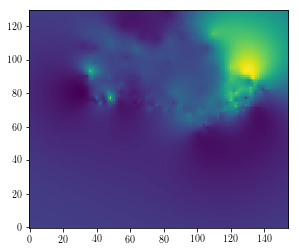

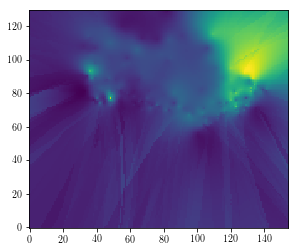

In [54]:
plt.imshow(krigfield[0].reshape(mean.shape), origin='lower')
plt.show()
plt.imshow(krigfield_mv_window[0].reshape(mean.shape), origin='lower')

In [55]:
matched_df.iloc[10:20]

,ilocy,ilocx,SL50 (kPa),ilocx_mask,ilocy_mask,rlat,rlon,lat,lon,station_name,ratio,label
10,60,103,2.500000,103.0,60.0,-2.230696,11.588573,44.093450,-80.693900,PRICEVILLE,1.351580,6
11,60,105,1.457143,105.0,60.0,-2.230696,12.480002,43.757143,-79.502757,RICHMOND HILL,0.969993,6
12,61,102,3.650000,102.5,60.5,-1.783874,11.142859,44.590017,-81.197150,WIARTON A,2.457898,6
13,61,104,1.800000,104.0,61.0,-1.783874,12.034287,44.151400,-79.872200,ALLISTON NELSON,0.951469,6
14,61,105,2.500000,105.0,61.0,-1.783874,12.480002,44.303100,-79.663750,COOKSTOWN,1.554745,6
15,61,106,3.100000,106.0,61.0,-1.783874,12.925716,44.297220,-78.528827,HALIBURTON A composite,1.840407,6
16,61,107,2.400000,107.0,61.0,-1.783874,13.371430,44.233300,-78.366700,PETERBOROUGH A,1.483778,6
17,61,108,1.466667,108.0,61.0,-1.783874,13.817145,44.116867,-77.531567,BELLEVILLE,0.965981,6
18,62,105,3.900000,105.0,62.0,-1.337053,12.480002,44.966700,-79.300000,MUSKOKA A,1.707163,6
19,62,108,3.300000,108.0,62.0,-1.337053,13.817145,44.393952,-77.627243,STIRLING composite,1.621613,6


In [56]:
i_to_drop = []
i_of_drop = []
Zl = []
# dfc = matched_df.copy()
# matched_df_region = dfc.copy()
# dfc = matched_df_region.copy()
dfc = matched_df.copy()

from sklearn.neighbors import NearestNeighbors
# nbrs = NearestNeighbors(n_neighbors=35, metric='euclidean').fit(X_distances.T)
# dist, ind = nbrs.kneighbors(X_distances.T)

loglike = []
reml = []
rmse = []
function_name = []

xc, yc = -10, 17.5
# i = 454
i = 0 
# i = 40
print("LON, LAT", df.lon[i], df.lat[i])

per_station_loglike = []

nneighs = np.arange(35, dfc.shape[0])

nug_arr = []
pykrige_variogram_parameters = []

# Three conditions to meet:

# 1.) At least 35 stations in a window [x]
# 2.) Minimum area must be 5x5 grid [x]
# 3.) Windows can not have greater than 50% coverage of any other window [x]

area = np.zeros(mean.shape)
X_distances = np.stack([dfc.rlon.values, dfc.rlat.values])
N = dfc.values.shape[0]

# for i in np.arange(N):
#     nn = 40
#     nbrs = NearestNeighbors(n_neighbors=nn, metric='euclidean').fit(X_distances.T)
#     dist, ind = nbrs.kneighbors(X_distances.T)
#     temp_df = dfc.iloc[ind[i]]

#     xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
#     ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

#     latlon = np.stack([temp_df.rlon, temp_df.rlat])
# #     stats = temp_df[station_dv]
#     stats = temp_df.ratio

#     lw, u = find_nearest_index(ds_mean.rlat.values, ymin), find_nearest_index(ds_mean.rlat.values, ymax)
#     l, r = find_nearest_index(ds_mean.rlon.values, xmin), find_nearest_index(ds_mean.rlon.values, xmax)
#     ylim = u-lw
#     xlim = r-l

#     try:
#         z, x, y, cov = sp.fit(latlon, stats, xlim, ylim)

#         final = mean.copy()
#         final[:, :] = np.nan
#         final[lw:u, l:r] = z.T#*mean[lw:u, l:r]
#         nanmask = ~np.isnan(final)
#     except:
#         pass
    
#     # increase neighbours until area condition is met
#     # the nearest stations must be >= 35 in all cases
#     while np.sum(nanmask) < (3*5)**2:
#         nn += 1
#         nbrs = NearestNeighbors(n_neighbors=nn, metric='euclidean').fit(X_distances.T)
#         dist, ind = nbrs.kneighbors(X_distances.T)

#         temp_df = dfc.iloc[ind[i]]

#         xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
#         ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

#         latlon = np.stack([temp_df.rlon, temp_df.rlat])
# #         stats = temp_df[station_dv]
#         stats = temp_df.ratio

#         lw, u = find_nearest_index(ds_mean.rlat.values, ymin), find_nearest_index(ds_mean.rlat.values, ymax)
#         l, r = find_nearest_index(ds_mean.rlon.values, xmin), find_nearest_index(ds_mean.rlon.values, xmax)
#         ylim = u-lw
#         xlim = r-l
#         try:
#             z, x, y, cov = sp.fit(latlon, stats, xlim, ylim)

#             final = mean.copy()
#             final[:, :] = np.nan
#             final[lw:u, l:r] = z.T#*mean[lw:u, l:r]
#             nanmask = ~np.isnan(final)
#         except:
#             pass
# #         print("Increase the area")


# #     area[lw:u, l:r] += 1.0
#     area[nanmask] += 1.0
#     # field already has kriged values in it? If so, where, True?
# #     n_tot = ylim*xlim
#     n_tot = np.sum(nanmask)
#     n_sum = np.sum(
# #                 area[lw:u, l:r] > 1.0
#                   area[nanmask] > 1.0
#             )

#     if float(n_sum)/n_tot >= 0.85:
#         area[lw:u, l:r] -= 1.0
#         continue
        
#     try:
#         z, x, y, cov = sp.fit(latlon, stats, xlim, ylim)
#         reml.append(np.sqrt(np.mean(np.array(cov['residuals'])**2)))

#         nugget, sill, range_r = cov['sigma.MLE'][0]**2, cov['rho.MLE'][0], cov['theta.MLE'][0]
#         function_name.append(cov['cov.function.name'][0])
#         nug_arr.append(nugget)

#         final = mean.copy()
#         final[:, :] = np.nan
#         final[lw:u, l:r] = z.T*mean[lw:u, l:r]
#         rmse.append(np.sqrt(np.nanmean(np.subtract(final[temp_df.ilocy, temp_df.ilocx], temp_df[station_dv])**2)))
#         Zl.append(final)

#     except:
# #         print("failure")
#         pass
# Zl = np.array(Zl)
from scipy.spatial import ConvexHull

dA = (np.amax(ds_mean.rlon.values)-np.amin(ds_mean.rlon.values))/ds_mean.rlon.size

print(dA)

for i in np.arange(N):
    nn = 40
    nbrs = NearestNeighbors(n_neighbors=nn, metric='euclidean').fit(X_distances.T)
    dist, ind = nbrs.kneighbors(X_distances.T)
    temp_df = dfc.iloc[ind[i]]

    xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
    ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

    latlon = np.stack([temp_df.rlon, temp_df.rlat])
#     stats = temp_df[station_dv]
    stats = temp_df.ratio

    lw, u = find_nearest_index(ds_mean.rlat.values, ymin), find_nearest_index(ds_mean.rlat.values, ymax)
    l, r = find_nearest_index(ds_mean.rlon.values, xmin), find_nearest_index(ds_mean.rlon.values, xmax)
    ylim = u-lw
    xlim = r-l

    hull = ConvexHull(points=latlon.T)
    
    # increase neighbours until area condition is met
    # the nearest stations must be >= 35 in all cases
    while hull.area < (dA**2)*(3*5)**2:
        nn += 1
        nbrs = NearestNeighbors(n_neighbors=nn, metric='euclidean').fit(X_distances.T)
        dist, ind = nbrs.kneighbors(X_distances.T)

        temp_df = dfc.iloc[ind[i]]

        xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
        ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

        latlon = np.stack([temp_df.rlon, temp_df.rlat])
        
        hull = ConvexHull(points=latlon.T)

#         stats = temp_df[station_dv]
        stats = temp_df.ratio

        lw, u = find_nearest_index(ds_mean.rlat.values, ymin), find_nearest_index(ds_mean.rlat.values, ymax)
        l, r = find_nearest_index(ds_mean.rlon.values, xmin), find_nearest_index(ds_mean.rlon.values, xmax)
        ylim = u-lw
        xlim = r-l

#         print("Increase the area")

    try:
        z, x, y, cov = sp.fit(latlon, stats, xlim, ylim)
        reml.append(np.sqrt(np.mean(np.array(cov['residuals'])**2)))

        nugget, sill, range_r = cov['sigma.MLE'][0]**2, cov['rho.MLE'][0], cov['theta.MLE'][0]
        function_name.append(cov['cov.function.name'][0])
        nug_arr.append(nugget)

        final = mean.copy()
        final[:, :] = np.nan
        final[lw:u, l:r] = z.T*mean[lw:u, l:r]
        rmse.append(np.sqrt(np.nanmean(np.subtract(final[temp_df.ilocy, temp_df.ilocx], temp_df[station_dv])**2)))
        nanmask = ~np.isnan(final)

        area[nanmask] += 1.0

        # field already has kriged values in it? If so, where, True?
        n_tot = np.sum(nanmask)
        n_sum = np.sum(
                      area[nanmask] > 1.0
                )

        if float(n_sum)/n_tot >= 0.75:
            area[lw:u, l:r] -= 1.0
        else:
            Zl.append(final)

    except:
        pass

Zl = np.array(Zl)

LON, LAT -123.742 48.935
0.4428387734996858


In [68]:
dfc.shape

(399, 12)

In [69]:
Zl.shape

(140, 130, 155)

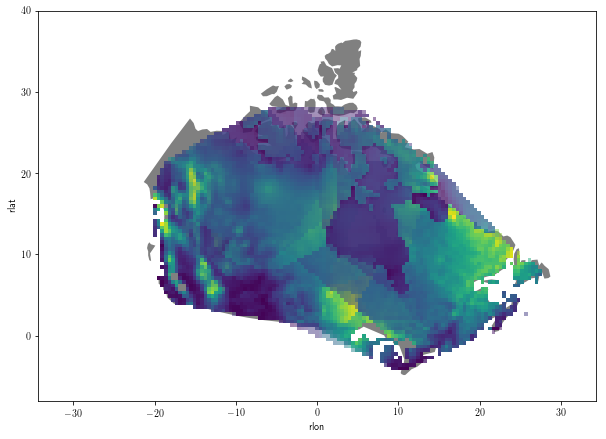

In [70]:
canada = gpd.read_file('../../climpyrical/tests/data/canada.geojson')
canada = rotate_shapefile(canada.geometry)

fig, ax = plt.subplots(figsize=(10,10))
for im in Zl:
    extent=[ds.rlon.min(), ds.rlon.max(), ds.rlat.min(), ds.rlat.max()]
    ax.imshow(im, origin='lower', alpha=0.5, extent=extent)
canada.plot(ax = ax, zorder = 0, color='grey')
plt.xlabel('rlon')
plt.ylabel('rlat')
plt.ylim(-8, 40)
plt.savefig("overlapping_regions")
plt.show()

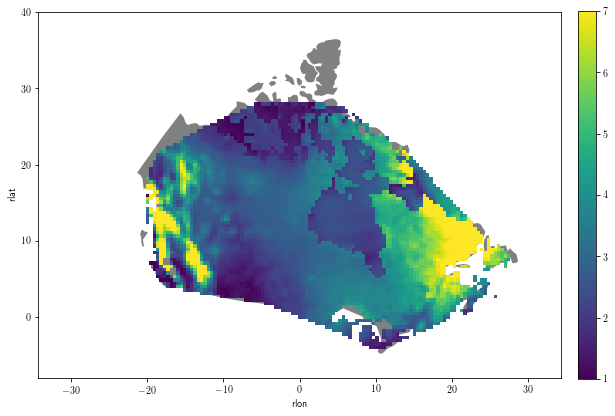

In [71]:
canada = gpd.read_file('../../climpyrical/tests/data/canada.geojson')
canada = rotate_shapefile(canada.geometry)

fig, ax = plt.subplots(figsize=(10,10))
# for im in Zl:
extent=[ds.rlon.min(), ds.rlon.max(), ds.rlat.min(), ds.rlat.max()]
col = ax.imshow(np.nanmean(Zl, axis=0), origin='lower', extent=extent, vmin=1.0, vmax=7.0)
canada.plot(ax = ax, zorder = 0, color='grey')
# plt.scatter(dfc.rlon, dfc.rlat)
plt.xlabel('rlon')
plt.ylabel('rlat')
plt.ylim(-8, 40)
plt.colorbar(col, pad=0.03, fraction=0.033)
plt.savefig("east_region_new_kriged")
plt.show()

In [72]:
# grid = np.meshgrid(x, y)[0]
# for i, rlon in enumerate(x):
#     for j, rlat in enumerate(y):
#         pt = Point(rlon, rlat)
#         grid[j, i] = p.contains(pt)
# return grid == 1.0

# np.stack([rlon.flatten(), rlat.flatten()])
x, y = flatten_coords(ds_mean.rlon, ds_mean.rlat)
xy = np.stack([x, y]).T
contained = []

for xcoord, ycoord in xy:
    contained.append(canada.contains(Point(xcoord, ycoord)))
    
contained = np.array(contained).reshape(ds_mean[dv].shape)

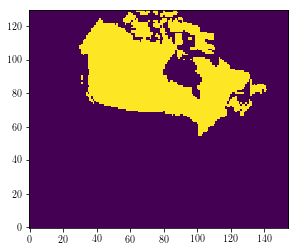

In [73]:
plt.imshow(contained, origin='lower')

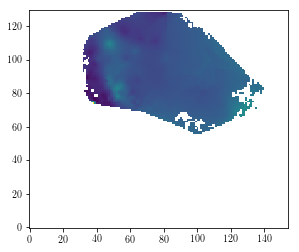

In [82]:
# gen_raster_mask_from_vector()
rec = np.nanmean(Zl, axis=0)
rec_nan = np.isnan(rec)
trouble_areas = np.logical_and(rec_nan, contained)
rec_ratio = rec/ds_mean[dv].values
# rlon[rec_nan].size, rlon.shape
# plt.imshow(np.logical_and(rec_nan, contained), origin='lower')
plt.imshow(rec_ratio, origin='lower')

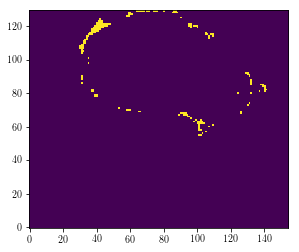

In [83]:
plt.imshow(trouble_areas, origin='lower')

In [81]:
rlon, rlat = np.meshgrid(ds_mean.rlon, ds_mean.rlat)

from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator

f = NearestNDInterpolator(np.stack([rlon[~rec_nan], rlat[~rec_nan]]).T, rec_ratio[~rec_nan])
rec_ratio[trouble_areas] = f(np.stack([rlon[trouble_areas], rlat[trouble_areas]]).T)

rec_final = rec_ratio*ds_mean[dv].values

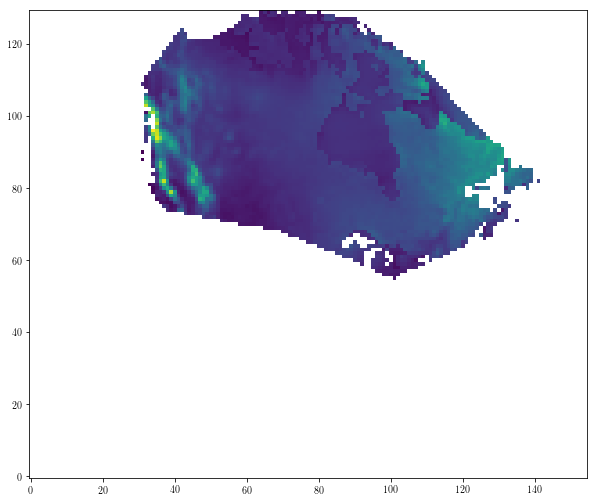

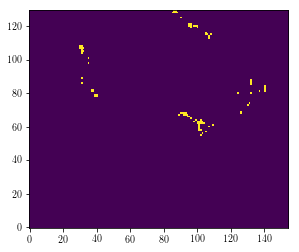

In [85]:
rec[trouble_areas] = ds_mean[dv].values[trouble_areas]
new_trouble_areas = np.logical_and(np.isnan(rec), contained)

f_lin = LinearNDInterpolator(np.stack([rlon[~rec_nan], rlat[~rec_nan]]).T, ds_mean[dv].values[~rec_nan])
rec_final[new_trouble_areas] = f_lin(np.stack([rlon[new_trouble_areas], rlat[new_trouble_areas]]).T)
plt.figure(figsize=(10, 10))
# plt.imshow(rec_final, origin='lower', vmin=1, vmax=5)
plt.imshow(rec_final, origin='lower')
plt.show()

plt.imshow(new_trouble_areas, origin='lower')

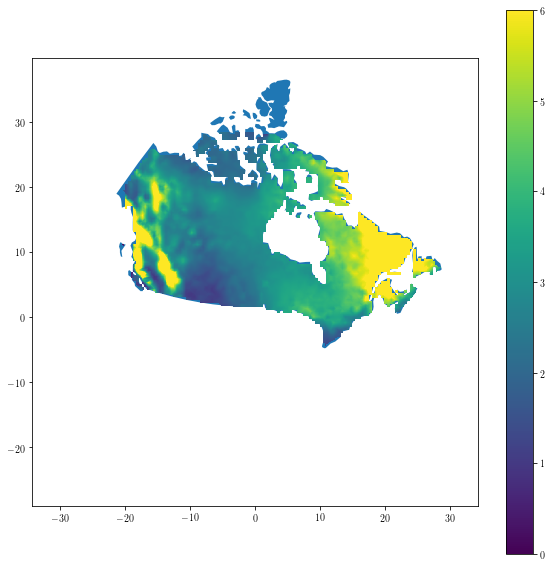

In [78]:
f_lin_full = LinearNDInterpolator(np.stack([rlon[final_mask], rlat[final_mask]]).T, rec_final[final_mask])
final_ds = ds_mean.copy()
n = 10
dx = np.diff(final_ds.rlon.values).mean() / n
dy = np.diff(final_ds.rlat.values).mean() / n

# define new boundaries
x1 = final_ds.rlon.min() - dx
x2 = final_ds.rlon.max() + dx
y1 = final_ds.rlat.min() - dy
y2 = final_ds.rlat.max() + dy

# define new coordinate arrays
new_x = np.linspace(x1, x2, final_ds.rlon.size * n)
new_y = np.linspace(y1, y2, final_ds.rlat.size * n)

new_x, new_y = flatten_coords(new_x, new_y)

new_final_field = f_lin_full(np.stack([new_x, new_y]).T).reshape((final_ds.rlat.size * n, final_ds.rlon.size * n))

# regridded_ds = xr.Dataset(
#     {dv: (["rlat", "rlon"], new_ds), "lon": ds.lon, "lat": ds.lat},
#     coords={
#         "rlon": ("rlon", new_x),
#         "rlat": ("rlat", new_y),
#         "level": ("level", ds.level.values.astype(int)),
#     },
# )
fig, ax = plt.subplots(figsize=(10, 10))
newmask = np.repeat(np.repeat(contained, n, axis=0), n, axis=1)
new_final_field[~newmask] = np.nan
col = plt.imshow(new_final_field, origin='lower', extent=extent, vmin=0, vmax=6)
plt.colorbar(col)
canada.plot(ax=ax, zorder=0)
plt.savefig('final_reconstruction')

In [67]:
nugget = np.array(pykrige_variogram_parameters)[:, 2]
sill = np.array(pykrige_variogram_parameters)[:, 0]
range = np.array(pykrige_variogram_parameters)[:, 1]

IndexError: too many indices for array

In [ ]:
plt.figure(figsize=(10, 10))
# plt.plot(np.delete(nneighs, i_of_drop), np.array(loglike), label='lnProfileLike')
plt.plot(np.delete(nneighs, i_of_drop), np.array(reml), label='RMSE Spatial Process')
plt.plot(np.delete(nneighs, i_of_drop), np.array(nug_arr), label='Fitted Nugget Spatial Process')
# plt.plot(np.delete(nneighs, i_of_drop), np.array(dof), label='Fitted Nugget')
plt.legend()
plt.xlabel('N Stations')
plt.ylabel('RMSE')

plt.show()

plt.figure(figsize=(10, 10))
plt.plot(nneighs, nugget, label='nugget PyKrige')
plt.plot(nneighs, rmse, label='RMSE PyKrige')
# plt.plot(nneighs, sill, label='sill PyKrige')
# plt.plot(nneighs, range*3, label='range PyKrige')

# plt.plot(np.delete(nneighs, i_of_drop), np.array(dof), label='Fitted Nugget')

# plt.plot(np.delete(nneighs, i_of_drop), np.array(rmse), label='RMSE')
plt.legend()
plt.xlabel('N Stations')
plt.ylabel('RMSE')
# plt.title('Error Profiles Western Canada')
# plt.savefig('error_profiles_east')

In [ ]:
S_R_tup = sp.fit(np.stack([matched_df.rlon, matched_df.rlat]), matched_df[station_dv], S.shape[0], S.shape[1])

In [ ]:
S_R = S_R_tup[0]

In [ ]:
plt.scatter(np.sort(S_R.flatten()), np.sort(S.flatten()))

In [ ]:
z, x, y, cov = sp.fit(latlon, stats, xlim, ylim)
rlonlon, rlatlat = latlon
print(cov)
fit_params_names = ["N", "nugget", "range", "sill"]
fit_params = dict(zip(fit_params_names, cov[[0, 1, 2, 6]]))
# fit_params, cov

In [ ]:
from pykrige.ok import OrdinaryKriging
okie = OrdinaryKriging(rlonlon, rlatlat, stats, variogram_model='exponential', coordinates_type = "geographic")
# krigfield = okie.execute('points', rlon[region], rlat[region], exact_values=False)
# okie.display_variogram_model()
print(okie.variogram_model_parameters)
print(fit_params)

In [ ]:
r = np.linspace(0, 25, 100)

def variogram(params):
    return params['nugget']+params['sill']*(1-np.exp(-r/params['range']))

plt.plot(r, variogram(fit_params))

In [ ]:
# cov
nugget = d['summary'][1]
range_ = d['summary'][2]
sill = d['summary'][4]

nugget, range_, sill

In [ ]:
fit_params['nugget']+fit_params['sigma']*(1.0-np.exp(-r/))

In [ ]:
list(dict(zip(d['MLEJoint'].names, list(d['MLEJoint'])))['optimResults'])

In [ ]:
# range (distance), degs of freedom, p-values
# least squares departure from
# get the three parameters from kriging from spatialProcess for the variogram
# reconstruct the variogram
# put together mean squared error measure
# 

In [ ]:
se_dict
z_se_full = mean.copy()
z_se_full[lw:u, l:r] = z_se.T

np.nanmean(z_se_full[dfc.ilocy, dfc.ilocx]), np.nanmean(z_se_full)

In [ ]:
plt.imshow(z_se_full, origin='lower', vmin=0, vmax=1)
plt.show()
plt.imshow(z, origin='lower', vmin=0, vmax=10)
plt.show()

In [ ]:
# i_to_drop = []
# # Zl = []
# dfc = matched_df.copy()
# nn = 10
# nx = 10
# ny = 6
# boxdx, boxdy = (dfc.rlon.values.max()-dfc.rlon.values.min())/nx, (dfc.rlat.values.max()-dfc.rlat.values.min())/ny

# xstarts = np.linspace(dfc.rlon.values.min()+boxdx/2, dfc.rlon.values.max()-boxdx/2, nx)
# ystarts = np.linspace(dfc.rlat.values.min()+boxdy/2, dfc.rlat.values.max()-boxdy/2, ny)

# # y box
# for yc in ystarts:
#     #x box
#     for xc in xstarts:
#         ndf = dfc.copy()
#         condition = (ndf.rlon < xc+boxdx) & (ndf.rlon > xc-boxdx) & (ndf.rlat < yc+boxdy) & (ndf.rlat > yc-boxdy)
#         ndf = ndf[condition]
        
#         latlon = np.stack([ndf.rlon.values, ndf.rlat.values])
#         stats = ndf[station_dv].values
# #     stats = dfc['ratio'].values[ind[i]]
    
#         lw, u = find_nearest_index(ds_mean.rlat.values, yc-boxdy), find_nearest_index(ds_mean.rlat.values, yc+boxdy)
#         l, r = find_nearest_index(ds_mean.rlon.values, xc-boxdx), find_nearest_index(ds_mean.rlon.values, xc+boxdx)
#         ylim = u-lw
#         xlim = r-l
#         try:
#             z, x, y = sp.fit(latlon, stats, xlim, ylim)
#             final = mean.copy()
#             final[:, :] = np.nan
#             final[lw:u, l:r] = z.T#*mean[lw:u, l:r]
#         except:
#             i_to_drop.append(u)
#             pass
    
#         Zl.append(final)

In [ ]:
Zl = np.array(Zl)
# Zl_del = np.delete(Zl, i_to_drop, axis=0)
Zlmean = np.nanmean(Zl, axis=0)

In [ ]:
sums = np.sum(~np.isnan(Zl), axis=0)
plt.figure(figsize=(10, 10))
plt.imshow(sums, origin='lower', cmap=plt.cm.get_cmap("Greys", 100))
col = plt.colorbar()
plt.savefig("overlap_regions")

In [ ]:
Zlmean

In [ ]:
# plt.imshow(Zl[50, ...], origin='lower')
plt.figure(figsize=(10, 10))
# plt.imshow(Zlmean, origin='lower', cmap=plt.cm.get_cmap("viridis", 10), vmin=0, vmax=10)
plt.imshow(Zlmean, origin='lower')

In [ ]:
# del Zl_del
# del d_arrc_del
# np.delete(d_arr, i_to_drop, axis=0).shape, Zl.shape

In [ ]:
extent=[ds.rlon.min(), ds.rlon.max(), ds.rlat.min(), ds.rlat.max()]

In [ ]:
Zl = np.array(Zl)
Zlfill = Zl.copy()
Zlfill[~np.isnan(Zl)] = 0.0
fig, ax = plt.subplots(figsize=(10, 10))
for img in Zlfill[:, ...]:
    ax.imshow(img, origin='lower', extent = extent, alpha=0.3)

canada = gpd.read_file('../../climpyrical/tests/data/canada.geojson')
canada = rotate_shapefile(canada.geometry)
canada.plot(ax = ax, zorder = 0, color='grey')
plt.savefig("moving_window_overlap_random")

In [ ]:
from scipy.spatial.distance import pdist
from sklearn.neighbors import KNeighborsRegressor

a = np.array([rlon[final_mask], rlat[final_mask]]).T
a1 = np.array([matched_df.rlon.values, matched_df.rlat.values]).T
def pwhole_def(alpha):
#     s=time.time()
    c = mean.copy()
    d = np.amin(distance.cdist(a, a1, metric='euclidean'), axis=1)
#     d = pairwise_distances_argmin_min(a, a1[i], metric='euclidean')[1]
    c[final_mask] = np.exp(-alpha*d)
    c[~final_mask] = np.nan
#     print("Time:", time.time()-s)
    return c

plt.imshow(pwhole_def(1.))

In [ ]:
Z = np.nanmean(Zl, axis=0)
plt.figure(figsize=(10, 10))
plt.imshow(Z, origin='lower', vmin=0, vmax=6)

In [ ]:
# ds_test = ds_mean.drop('time')
# ds_test.assign('snw', Z)
# regridded_ds = xr.Dataset(
#     {dv: (["rlat", "rlon"], ds_mean), "lon": ds.lon, "lat": ds.lat},
#     coords={"rlon": ("rlon", new_x), "rlat": ("rlat", new_y)},
# )
ds_test = ds.copy()
A = ds[dv].values
A[0, ...] = Zlmean

ds_test = ds_test.assign({'snw': (["levels", "rlat", "rlon"], A)})
ds_test.to_netcdf('/home/nannau/06022020/dash-dv-explorer/assets/data/sl50_krig_reconstruction_stations.nc')

In [ ]:
ds_test[dv].shape[1:]

# Clustering

In [ ]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler

std = StandardScaler() 
N = 10
db = KMeans(n_clusters=N)
# db = DBSCAN(eps=0.2, min_samples=30, metric='haversine')

X = np.stack([matched_df.rlon, matched_df.rlat]).T
# X
# X = std.fit_transform(X.T)
db.fit(X)

db.labels_.shape, matched_df.shape[0]

matched_df = matched_df.assign(label = db.labels_)

sns.distplot(db.labels_, kde=False)

In [ ]:
ccenters = db.cluster_centers_
xcenter, ycenter = ccenters[:, 0], ccenters[:, 1]
xcenter, ycenter

In [ ]:
from scipy.spatial.distance import pdist
def pwhole_(alpha):
    rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
    d_gridx = np.dstack((rlon, rlat))

    a = np.array([rlon[final_mask], rlat[final_mask]]).T
    a1 = np.array([xcenter, ycenter]).T

    d = cdist(a, a1)
    
#     d = db.kneighbors_graph(a, mode='distance').toarray()
#     denom = np.exp(-alpha*np.sum(np.sort(d, axis=1)[:, :1], axis=1))
#     num = np.exp(-alpha*np.sort(distance.cdist(a, a1), axis=1)[:, 0])

    p = np.exp(-alpha*d)#np.sort(d, axis=0))
    print(p.shape)
    pwhole = mean.copy()
    pwhole[final_mask] = pwhole
    pwhole[~final_mask] = np.nan
    return pwhole.reshape(mean.shape)


# plt.figure(figsize=(10, 10))
# plt.imshow(pwhole_(.5), origin='lower', vmin=0, vmax=1)
# np.nanmax(pwhole_(0.1))

In [ ]:
plt.figure(figsize=(8, 7))
print(np.unique(db.labels_).size)
sns.scatterplot(matched_df.rlon, matched_df.rlat, palette=sns.color_palette('muted', n_colors=N), hue=db.labels_)
sns.scatterplot(xcenter, ycenter, color = 'black', marker='x')
plt.title("K-Means Clustering on Station Data SL50")
plt.savefig('K-MeansCluster')

# Tool modifications:
* Extend ratios to station locations using closest model value - i.e. grid points behind stations using nearest 
* increase font sizes

# Tool notes:
* Understanding the audience
* Engineers tasked with building things
* Primary interest is a location:
* Point to a location select list of design values to get information from 
* Type in lat and lon and extract the design values
* Place a pin and get other design values or csv file/ascii file (secondary priority)
* New tab with selection of final design values


In [ ]:
S = Z.copy()
rmse = {
    'S_st': np.sqrt(mean_squared_error(S[dfc.ilocy, dfc.ilocx], dfc[station_dv])),
#     'R_b_st': np.sqrt(mean_squared_error(R_b[dfc.ilocy, dfc.ilocx], dfc[station_dv])),
    's_mod': np.sqrt(mean_squared_error(mean[dfc.ilocy, dfc.ilocx], dfc[station_dv])),
    'S_mod': np.sqrt(mean_squared_error(S[region], mean[region])),
#     'R_b_mod': np.sqrt(mean_squared_error(R_b[region], mean[region])),
}

bias = {
    'S_st': np.mean(S[dfc.ilocy, dfc.ilocx] - dfc[station_dv]),
    's_mod': np.mean(mean[dfc.ilocy, dfc.ilocx] - dfc[station_dv]),
    'S_mod': np.mean(mean[region] - S[region]),
}

rmse, bias

In [ ]:
tp = {
    'northern': {
        'x1': -20,
        'y1': 0,
        'x2': -20,
        'y2': 25.5,
        'x3': -20,
        'y3': 10,
    },
    'eastern': {
        'x1': 23,
        'y1': 0,
        'x2': 5,
        'y2': 12,
        'x3': 23,
        'y3': 0,
    },
    'western': {
        'x1': -5,
        'y1': 0,
        'x2': -20,
        'y2': 14,
        'x3': -5,
        'y3': 4,
    },
}
key = 'eastern'
text = tp[key]

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(45, 20))
zmin,zmax = -.5, np.amax(dfc[station_dv])+1.2
bmin, bmax = .6, 2.5
c = plt.cm.get_cmap("viridis_r", 10)
errorc = plt.cm.get_cmap("jet", 10)
extent=[dfc.rlon.min(), dfc.rlon.max(), dfc.rlat.min(), dfc.rlat.max()]
clevels = np.linspace(1, 15, 8) 

# Tile 0, 0
pos=(0, 0)
stations_only = ax[pos].scatter(dfc.rlon, dfc.rlat, c = dfc[station_dv], cmap=c,  vmin=zmin, vmax=zmax)
ax[pos].set_title('Stations SL50 (kPa) [$s$]', fontsize=15, weight='bold') 
ax[pos].text(text['x1'], text['y1'], f'count pre match: {df[region_cond_df].shape[0]}', fontsize=15)
ax[pos].text(text['x1'], text['y1']-1, f'count post match: {dfc.shape[0]}', fontsize=15)
plt.colorbar(stations_only, ax=ax[pos])

# Tile 0, 1
pos = (0, 1)
S_plot = ax[pos].imshow(regionalize(S), origin='lower', aspect='auto', extent=extent, cmap=c, vmin=zmin, vmax=zmax)
ax[pos].set_title('Station Only Reconstruction SL50 (kPa) [$S$]', fontsize=15, weight='bold') 
S_plot_ct = ax[pos].contour(
    regionalize(rlon), 
    regionalize(rlat), 
    regionalize(S), 
    colors = ['black'], 
    levels = clevels)
ax[pos].clabel(S_plot_ct)
plt.colorbar(S_plot, ax=ax[pos])

# Tile 0, 3
pos = (1,0)
ens_mean = ax[pos].imshow(regionalize(mean), origin='lower', aspect='auto', extent=extent, cmap=c, vmin=zmin, vmax=zmax)
ax[pos].set_title(r'Ensemble Mean SL50 (kPa) [$\mu$]', fontsize=15, weight='bold') 
mean_ct = ax[pos].contour(
    regionalize(rlon), 
    regionalize(rlat), 
    regionalize(mean), 
    colors = ['black'], 
    levels = clevels)
ax[pos].clabel(mean_ct)
plt.colorbar(ens_mean, ax=ax[pos])

# Tile 1, 0
# pos = (1, 2)
# stations_only_b = ax[pos].scatter(dfc.rlon, dfc.rlat, c = dfc.ratio, cmap=c, vmin=bmin, vmax=bmax)
# ax[pos].set_title('Station/Model Ratio [$b$]', fontsize=15, weight='bold') 
# plt.colorbar(stations_only_b, ax=ax[pos])

# Tile 1, 1
# pos = (2, 1)
# B_plot = ax[pos].imshow(regionalize(R_b), origin='lower', aspect='auto', extent=extent, cmap=c, vmin=zmin, vmax=zmax)
# ax[pos].set_title(r'Post Bias Reconstruction SL50 (kPa) [$R_b=B \times \mu$]', fontsize=15, weight='bold') 
# B_plot_ct = ax[pos].contour(
#     regionalize(rlon), 
#     regionalize(rlat), 
#     regionalize(R_b), 
#     colors = ['black'], 
#     levels = clevels)
# ax[pos].clabel(B_plot_ct)
# plt.colorbar(B_plot, ax=ax[pos])

# Tile 2, 0
# stations_only_post_bias = ax[2, 0].imshow(regionalize(B), origin='lower', aspect='auto', extent=extent, cmap=c, vmin=bmin, vmax=bmax)
# ax[2, 0].set_title('Bias Reconstruction, [$B$]', fontsize=15, weight='bold') 
# ct_S_only_ps = ax[2, 0].contour(
#     regionalize(rlon), 
#     regionalize(rlat), 
#     regionalize(B), 
#     colors = ['black'], 
#     levels = np.linspace(0, 5, 10))
# ax[2, 0].clabel(ct_S_only_ps)
# plt.colorbar(stations_only_post_bias, ax=ax[2, 0])

# plt.savefig('tile_plot_sl50_east_krig.png')

In [ ]:
from rpy2.robjects.packages import importr
from rpy2 import robjects
import numpy as np
importr('fields', lib_loc='../r-library/fields')

In [ ]:
latlon = np.stack([dfc.rlon, dfc.rlat])
stats = dfc[station_dv].values
import climpyrical.spytialProcess as sp

In [ ]:
# r['surface'](tr)
import climpyrical.spytialProcess as sp
u, lw, l, rside
ylim = lw-u
xlim = rside-l
print(xlim, ylim)
z, x, y = sp.fit(latlon, stats, xlim, ylim)
z.shape

In [ ]:
lw-u

In [ ]:
u, lw, l, rside

In [ ]:
# z = np.array(list(dict(zip(tr.names, list(tr)))['z'])).reshape(ylim, xlim)
Z = mean.copy()
Z[~final_mask] = np.nan
Z[u:lw, l:rside] = z.T

In [ ]:
# region.shape[0], region.shape[1], Z[u:lw, l:r].size, z.size
Z[~final_mask] = np.nan

In [ ]:
plt.imshow(regionalize(Z), origin='lower')
x.size, y.size


In [ ]:
nanmaskz = ~np.isnan(Z[dfc.ilocy, dfc.ilocx])
krigz = Z[dfc.ilocy, dfc.ilocx][nanmaskz]

In [ ]:
plt.scatter(krigz, dfc[station_dv].values[nanmaskz])

In [ ]:
np.sqrt(mean_squared_error(krigz, dfc[station_dv].values[nanmaskz]))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
zmin,zmax = -.5, np.amax(dfc[station_dv])+1.2
bmin, bmax = .6, 2.5
c = plt.cm.get_cmap("viridis_r", 10)
errorc = plt.cm.get_cmap("jet", 10)
extent=[dfc.rlon.min(), dfc.rlon.max(), dfc.rlat.min(), dfc.rlat.max()]
clevels = np.linspace(0, 12, 4) 
print(clevels)
clevels = [0, 2, 4, 6, 8, 12]

# Tile 0, 0
# pos=(0, 0)
pos = 0
stations_only = ax[pos].scatter(dfc.rlon, dfc.rlat, c = dfc[station_dv], cmap=c,  vmin=zmin, vmax=zmax)
ax[pos].set_title('Northern Stations SL50 (kPa) [$s$]', fontsize=15, weight='bold') 
# ax[pos].text(text['x1'], text['y1'], f'count pre match: {df[region_cond_df].shape[0]}', fontsize=15)
# ax[pos].text(text['x1'], text['y1']-1, f'count post match: {dfc.shape[0]}', fontsize=15)
plt.colorbar(stations_only, ax=ax[pos])

# Tile 0, 1
# pos = (0, 1)
pos = 1
S_plot = ax[pos].imshow(regionalize(Z), origin='lower', aspect='auto', extent=extent, cmap=c, vmin=zmin, vmax=zmax)
ax[pos].set_title('Northern Station Only Reconstruction Kriged SL50 (kPa) [$S$]', fontsize=15, weight='bold') 
S_plot_ct = ax[pos].contour(
    x, 
    y, 
    z, 
    colors = ['black'], 
    levels = clevels)
ax[pos].clabel(S_plot_ct)
plt.colorbar(S_plot, ax=ax[pos])

# # Tile 0, 3
# pos = (1,0)
# ens_mean = ax[pos].imshow(regionalize(mean), origin='lower', aspect='auto', extent=extent, cmap=c, vmin=zmin, vmax=zmax)
# ax[pos].set_title(r'Ensemble Mean SL50 (kPa) [$\mu$]', fontsize=15, weight='bold') 
# mean_ct = ax[pos].contour(
#     regionalize(rlon), 
#     regionalize(rlat), 
#     regionalize(mean), 
#     colors = ['black'], 
#     levels = clevels)
# ax[pos].clabel(mean_ct)
# plt.colorbar(ens_mean, ax=ax[pos])
plt.savefig('/home/nannau/Pictures/krig_example.png')

In [ ]:
'c'+str((1, 2))

In [ ]:
import climpyrical.spytialProcess as sp

In [ ]:
latlon = np.stack([dfc.rlon, dfc.rlat])
stats = dfc[station_dv].values
latlon.shape, type(latlon)

In [ ]:
latlon.shape[0], stats.size
import typing
var = 'x'
# isinstance(latlon, NDArray[(2, typing.Any), float])
# var: NDArray[(2, typing.Any), float]
# 
# var: typing.List
N = 10

xx, yy = np.meshgrid(np.linspace(0, 50, N), np.linspace(-25, 25, N), sparse=True)
nxx, nyy = flatten_coords(np.linspace(0, 50, N), np.linspace(-25, 25, N))
z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)
coords = np.stack([nxx, nyy])

In [ ]:
# z, x, y = sp.fit(latlon, stats, 80, 80, (1,2), 'geo', 'exponential')
z, x, y = sp.fit(coords, z.flatten(), N, N, (1,2), 'geo', 'exponential')

In [ ]:
plt.imshow(z)

In [ ]:
isinstance(np.empty((2, 5)), NDArray[(2, Any), float])